# Brex Data Challenge

## Abstract

**Task: Calculate the approximate total daily balance per customer**

Because of the complexity of the task, I use python to do data manipulation and calculation.

According to **customer_accounts** and **financial_accounts** tables, we find one individual customer probably have multiple financial accounts. Thus the first step is to compute the sum of each customer's balance & transaction amount by using `group_by`.


According to both **financials_balances** and **financials_transactions** tables, we find some balance amout are missing in a specific datetime range. However, some of them can be computed by the information of financials_transactions table. That is:

- *Balance(t) + Transaction(t) = Balance(t+1)*

- *Balance(t) - Transaction(t-1) = Balance(t-1)*

Thus the second step is to get these computable balance amount by shifting by 1 day. **Note that** the recursive function probably run multiple times, so here I set a loop for the shifting calculation until there is no more new balance amount gained.

Finanlly, I apply the method over all **customer_accounts** and construct the target DataFrame.

Pleach check my code for more information, some explainations are included in comments.

## Initialization

In [1]:
# Check python version
# -*- coding: utf-8 -*-

import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]'

In [2]:
from collections import Iterable

import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

In [3]:
# Make sure all csv files are in the same work path

CustomerAccounts = pd.read_csv("./customer_accounts.csv")
FinancialAccounts = pd.read_csv("./financials_accounts.csv")
FinancialBalances = pd.read_csv("./financials_balances.csv")
FinancialTransactions = pd.read_csv("./financials_transactions.csv")

## Quick check of all tables

In [4]:
CustomerAccounts.head()

,id,name
0,aacc_c10cwqghq00001owfyvwq126,Customer account 1
1,aacc_c8lodc9z00001pjfyvwq126,Customer account 2
2,aacc_czj999vto000j1mo1qkb1ydg,Customer account 3
3,aacc_celx54f0r000a1qqh4lnefn9,Customer account 4
4,aacc_cnq7b2pys000a1t4h4lnefn9,Customer account 5


In [5]:
FinancialAccounts.head()

,id,customer_account_id,name
0,finacc_ctzrz94k00051v354687jg1,aacc_c10cwqghq00001owfyvwq126,Bank account 1
1,finacc_ctzrz8vz00031v3wyouo0dk,aacc_c10cwqghq00001owfyvwq126,Bank account 2
2,finacc_ctzrz91d00041v3h6cklh2s,aacc_c10cwqghq00001owfyvwq126,Bank account 3
3,finacc_ctzrz98x00071v3k3hz7qls,aacc_c10cwqghq00001owfyvwq126,Bank account 4
4,finacc_ctzrz9aw00081v3ghgxf64s,aacc_c10cwqghq00001owfyvwq126,Bank account 5


In [6]:
FinancialBalances.head()

,id,account_id,amount,accrual_date
0,finblce_clqsroena000b1o70b5d0240d,finacc_clqsrob7p000a1o70h4lnefn9,20000000,2018-03-27
1,finblce_clr5aflhj008l1o70d0i79s1u,finacc_clr5afi01008k1o703vlrv3it,666181756,2017-10-13
2,finblce_clt7z6u9500b41o70np8qcjsr,finacc_clr5afi01008k1o703vlrv3it,414855384,2018-03-28
3,finblce_clv20f0yn00lu1o70kn9jksah,finacc_clqsrob7p000a1o70h4lnefn9,20000000,2018-03-28
4,finblce_csb6sn3tc0003e5a8wyouo0dk,finacc_csb6smrli0002e5a8b7haliai,12571741,2018-03-30


In [7]:
FinancialTransactions.head()

,id,account_id,amount,accrual_date
0,fintrn_clqswgddo000d1o70bw046m1l,finacc_clqsrmqo800081o70ghgxf64s,-1142,2017-10-04
1,fintrn_clqswgdgq000e1o707aru17jl,finacc_clqsrmqo800081o70ghgxf64s,-1800,2017-10-02
2,fintrn_clqsz0mzq000i1o700nzc0xi4,finacc_clqsrob7p000a1o70h4lnefn9,1043933,2018-03-26
3,fintrn_clqsz0n1b000j1o701qkb1ydg,finacc_clqsrob7p000a1o70h4lnefn9,-1200,2018-03-26
4,fintrn_clqsz0n2z000k1o70zkcqk7ti,finacc_clqsrob7p000a1o70h4lnefn9,-986752,2018-03-26


### Some Findings and Decisions
- These 4 tables are obviously related by the `id` columns, 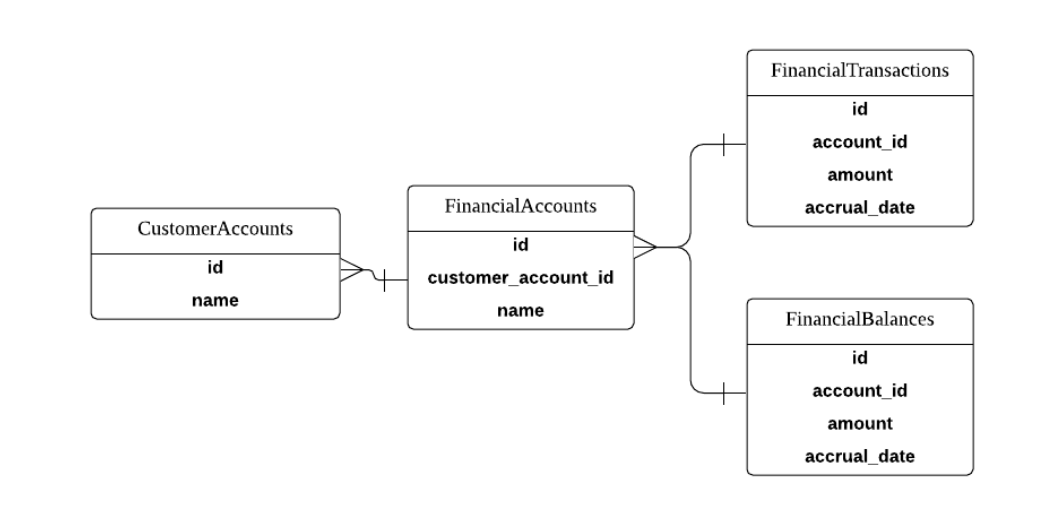
- Check the `CustomerAccounts.id` & `FinancialAccounts.customer_account_id`, there is an non-corresponding issue, I will use the union set of both as the total customers to output.
- Some accounts' `FinancialBalance.amount` & `FinancialTransctions.amount` are not correctly computed, I will assume the `FinancialBalance.amount` is always correct when conflicting with `FinancialTransctions.amount`.
- Due to the date range is required for 2017-01-01 to 2018-09-22, I will fill NA(where customers' balance can't be calculated by related balance and transactions) with the newest date's balance. 
- For some customers who appear in `CustomerAccounts` while don't have any Financial Account, I will leave their daily balance as 0.

## Define Generic Function

In [8]:
def calculate_balance(account_id: str, start_date: str = "2017-01-01", end_date: str = "2018-09-22") -> np.ndarray:
    
    """
    This function is to do multiple table join and manipulation to get the daily balance for single `account_id` from `start_date` 
    to `end_date`.
    
    Note: Before running this function, make sure `CustomerAccounts`, `FinancialAccounts`, `FinancialBalances`, `FinancialTransactions`
    are correctly defined.
    
    Args:
        account_id (int): The string object in CustomerAccounts["id"].
        start_date (str): Datetime (%Y-%m-%d).Default = "2017-01-01".
        end_date (str): Datetime (%Y-%m-%d). Default = "2018-09-22".

    Returns:
        np.ndarray, the daily balance for single `account_id` from `start_date` to `end_date`.
    """
    
    # Define date_range and initialize the balance_df 
    date_range = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d").tolist()
    balance_df = pd.DataFrame(date_range, columns=["accrual_date"]).set_index("accrual_date")
    
    # Find all financial accounts of the individual customer
    financial_acc_id = FinancialAccounts[FinancialAccounts["customer_account_id"] == account_id]["id"].values
    
    # Do group_by sum to get the total amount for the individual customer
    financial_balance_df = FinancialBalances[FinancialBalances["account_id"].isin(financial_acc_id)].groupby("accrual_date").sum()
    financial_balance_df = financial_balance_df.rename(columns={"amount": "balance"})
    financial_transaction_df = FinancialTransactions[FinancialTransactions["account_id"].isin(financial_acc_id)].groupby("accrual_date").sum()
    financial_transaction_df = financial_transaction_df.rename(columns={"amount": "transaction"})
    
    # Do left join for tables by their foreign keys
    balance_df = balance_df.join(financial_balance_df).join(financial_transaction_df)
    nan_count = balance_df["balance"].isna().sum()
    nan_filled = 100
    nan_index = balance_df[balance_df["balance"].isna()].index

    # Calculate missing balance by other related balance amount and transaction amount
    # Loop stop means all computable missing balance is filled
    while nan_filled > 0:
        balance_df["balance"] = balance_df["balance"].fillna((balance_df["balance"] + balance_df["transaction"]).shift(1))
        balance_df["balance"] = balance_df["balance"].fillna(balance_df["balance"].shift(-1) - balance_df["transaction"])
        # print(nan_count)
        nan_filled = nan_count - balance_df["balance"].isna().sum() 
        nan_count = balance_df["balance"].isna().sum() 
        
    # Fill uncomputable miss balance by newest date
    balance_df = balance_df.drop(columns="transaction")
    balance_df = balance_df.fillna(method="bfill")
    balance_df = balance_df.fillna(method="ffill")
    balance_df = balance_df.fillna(0)
    
    return balance_df.T.values[0]

## Bulid Target Table

In [9]:
# Get all customer ids
customer_account_id = list(set(CustomerAccounts["id"]).union(set(FinancialAccounts["customer_account_id"])))
print("The total number of customers is: ", len(customer_account_id))

# Build target DataFrame
CustomerDailyBalance = pd.DataFrame(customer_account_id, columns={"customer_account_id"})

The total number of customers is:  1607


In [10]:
# Apply function `calculate_balance` to column `customer_account_id`
balance_df = pd.DataFrame(CustomerDailyBalance["customer_account_id"].progress_apply(calculate_balance).values.tolist(),
                          columns=pd.date_range(start="2017-01-01", end="2018-09-22").strftime("%Y-%m-%d").tolist()
)

# Concatenate account_id and balance
CustomerDailyBalance = pd.concat([CustomerDailyBalance, balance_df], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 1607/1607 [01:33<00:00, 17.21it/s]


In [11]:
# Output target dataframe as csv
CustomerDailyBalance.to_csv("./customer_daily_balance.csv")

CustomerDailyBalance

,customer_account_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22
0,cuacc_c75zhmxvr02a610e5vx5qvuo,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.348039e+07,1.339959e+07,1.354056e+07,1.354056e+07,1.354056e+07,1.298850e+07,1.549746e+07,2.549746e+07,2.551842e+07,2.551842e+07
1,cuacc_cmxaj7zan00iu17vott7mdpe,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.414395e+09,4.179964e+09,4.467071e+09,4.467071e+09,4.467071e+09,4.356893e+09,4.339614e+09,4.351681e+09,4.378598e+09,4.378598e+09
2,cuacc_cltju5d3d01lw1v7nhgubndi,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,5.290950e+05,...,2.730200e+04,1.466580e+05,1.123680e+05,2.530200e+04,4.111900e+04,2.805400e+04,7.534000e+04,8.395100e+04,8.395100e+04,8.395100e+04
3,cuacc_cfbzzm3qe00pi1toxuoqkr67,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,7.813400e+04,...,1.843600e+04,1.843600e+04,1.843600e+04,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02,4.360000e+02
4,cuacc_c4yl48cdr035g1wxddzl4qwz,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,2.444640e+07,...,3.988229e+06,3.891391e+06,3.822973e+06,3.822973e+06,3.822973e+06,3.765483e+06,3.450481e+06,3.438482e+06,1.210213e+06,1.210213e+06
5,cuacc_cszdoezh5000r1x1e5prlisl,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,6.679885e+08,...,6.679885e+08,6.679885e+08,2.226628e+08,2.226628e+08,2.229574e+08,2.229574e+08,2.229574e+08,2.248242e+08,2.256094e+08,2.256094e+08
6,cuacc_cfyrvkibd00531961wrul0az,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.384064e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07,3.192436e+07
7,cuacc_c4t1l4qk102jk1xjks341lgk,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,7.709270e+07,...,3.328335e+08,3.481366e+08,3.472840e+08,3.472840e+08,3.472840e+08,3.472809e+08,3.512604e+08,3.507532e+08,3.507144e+08,3.507144e+08
8,cuacc_cyjtgclv502bl1x0g7p81shp,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,...,2.659827e+08,2.659827e+08,2.659827e+08,2.659827e+08,2.659669e+08,2.653220e+08,2.625581e+08,2.618392e+08,2.615840e+08,2.615840e+08
9,cuacc_c5xvd21ob02xu1xfk1zdcfs0,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,1.531186e+07,...,1.703112e+06,1.715708e+06,3.105810e+05,3.105810e+05,3.105810e+05,2.805105e+06,2.569685e+06,2.334265e+06,2.334265e+06,2.334265e+06


## Unit Test

The purpose of unit testing is to ensure the most atomic behavioral units of a system work as expected. Though it looks meaningless here, it's very extremely important for a framwork or tool package development.

In [12]:
account_list = ["cuacc_c5jodvu5c02zz1vb33b7g5eu", "cuacc_ch6h1s2da0jly1qzbhnriduk"]

for account in account_list:
    daily_balance = calculate_balance(account)
    assert np.isnan(daily_balance).sum() == 0
    assert len(daily_balance) == 630